© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/postdocs/mariia-seleznova/index.html), 2025. [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

# 🏠 Homework 5 — Lasso on Boston Housing Dataset

The goal of this task is to implement Lasso regression and apply it to the [Boston housing dataset](http://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html).

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os

import numpy as np
import pandas as pd

## Load the Data

In [2]:
file_name = 'boston_housing.csv'
url = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, index_col=0)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url)
    df.to_csv(file_name)
    print('Done.')

Loading data from `https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv`...
Done.


In [3]:
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


## Train-Test Split

In [4]:
def  train_test_split(df, training_data_fraction, shuffle=True):
    
    if shuffle is True:
        df_ = df.sample(frac=1).reset_index(drop=True)
    else:
        df_= df
    
    train_df = df_.iloc[:round(training_data_fraction*len(df_)),:]
    test_df = df_.iloc[round(training_data_fraction*len(df_)):,:]
    
    return df_, train_df, test_df

def normalize(x):
    return (x - np.mean(x, axis=0))/np.std(x,axis=0)

In [5]:
training_data_fraction = .8

df, train_df, test_df =  train_test_split(df, training_data_fraction)

X = normalize(df.iloc[:,df.columns != 'medv'].to_numpy())
Y = df.iloc[:,df.columns == 'medv'].to_numpy().reshape(-1)

train_X = normalize(train_df.iloc[:,df.columns != 'medv'].to_numpy())
train_Y = train_df.iloc[:,df.columns == 'medv'].to_numpy().reshape(-1)

test_X = normalize(test_df.iloc[:,df.columns != 'medv'].to_numpy())
test_Y = test_df.iloc[:,df.columns == 'medv'].to_numpy().reshape(-1)

## Linear Regression Class

First, we implement a basic linear regression model as a Python class `LinearRegression`.  
It is analogous to the `LinearBinaryClassification` class, except it returns the **decision function output** (via the `__call__` method), rather than a binary classification label.

Next, we define a `LassoRegression` class as a **child class** of `LinearRegression`, using **gradient descent (GD)** as the training method.

> ### 💡 Gradients for Lasso Regression
>
> The Lasso regression objective is:
>
> $$
> \mathcal{L}(w, b) = \frac{1}{2N} \|Xw + b\mathbf{1}_N - Y\|_2^2 + \lambda \|w\|_1
> $$
>
> **Gradient with respect to** $w$ (approximate, since $\|w\|_1$ is non-differentiable at 0):
>
> $$
> \nabla_w \mathcal{L}(w, b) = \frac{1}{N} X^T (Xw + b\mathbf{1}_N - Y) + \lambda \cdot \text{sign}(w)
> $$
>
> Here, $\text{sign}(w)$ is applied **component-wise**, and we assume:
> $$
> \frac{d}{dx}|x| \approx \text{sign}(x)
> $$
> which is valid almost everywhere.
>
> **Gradient with respect to** $b$ (same as in least squares):
>
> $$
> \nabla_b \mathcal{L}(w, b) = \frac{1}{N} \mathbf{1}_N^T (Xw + b\mathbf{1}_N - Y)
> $$

In [11]:
class LinearRegression:
    """
    Linear regression class.

    Stores a linear regression model with parameters (w,b)
    and decision function h(x) = sign(w @ x + b)

    Parameters:
    ----------
    w: array
    b: array

    """
    def __init__(self, w, b):
        self.w = w
        self.b = b

    def __call__(self, x):
        return x @ self.w + self.b
    

class LassoRegression(LinearRegression):
    """
    Lasso regression model trained with GD
    """
    def __init__(self, w, b, lam=0.1):
        super().__init__(w, b)
        self.lam = lam


    def loss_grad(self, X,Y):
        """Loss gradient"""
        residual = self(X) - Y
        w_grad = X.T@residual/X.shape[0] + self.lam*np.sign(self.w)
        b_grad = np.mean(residual, axis=0)
        return w_grad, b_grad
    
    def update(self, X, Y, lr = 1e-3):
        """Single step of GD"""
        grad_w, grad_b = self.loss_grad(X,Y)
        self.w -= lr*grad_w
        self.b -= lr*grad_b
               
    def fit(self, X, Y, lr = 1e-3, num_iter = 100):
        """GD training loop with num_iter epochs"""
        for _ in range(num_iter):
            self.update(X, Y, lr)
            
        return self.w, self.b

In [16]:
def mean_squared_error(y_pred,y_true):
    """Loss function"""
    return 0.5*np.mean((y_pred - y_true)**2, axis=0)

## Regularization Effects

As in the exercise class, we now explore how the **Lasso model's performance** and the **norm of its coefficients** vary as a function of the regularization parameter $ \lambda $.

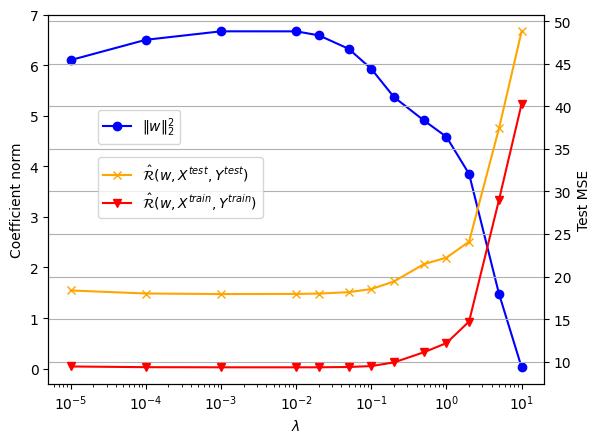

In [23]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

w = np.array([0.]*X.shape[-1])
b = 0.

ls = [1e-5,1e-4,1e-3,1e-2,2e-2,5e-2,1e-1,0.2,0.5,1.,2,5,10]
w_norms = []
test_losses = []
train_losses = []
w_s = []

for l in ls:

    model = LassoRegression(w, b, lam=l)
    model.fit(train_X,train_Y, lr = 1e-3, num_iter = 10000)
    
    w_norms.append(np.linalg.norm(model.w))
    test_losses.append(mean_squared_error(model(test_X),test_Y))
    train_losses.append(mean_squared_error(model(train_X),train_Y))
    w_s.append(model.w.copy())
    

ax.plot(ls, w_norms, color = 'blue', marker='o', label = '$\\|w\\|^2_2$')   
ax2.plot(ls, test_losses, color = 'orange', marker='x', label = '$\\hat{\\mathcal{R}}(w,X^{test},Y^{test})$')   
ax2.plot(ls, train_losses, color = 'red', marker='v', label = '$\\hat{\\mathcal{R}}(w,X^{train},Y^{train})$')   
ax.set_xscale('log')
    
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('Coefficient norm')
ax2.set_ylabel('Test MSE')
plt.grid()
ax.legend(loc=(0.1,0.65))
ax2.legend(loc=(0.1,0.45))

## Sparsity Tracking

We now visualize how the **individual coefficients** in the Lasso model change as a function of the regularization parameter $ \lambda $. As $ \lambda $ increases, the Lasso penalty encourages more coefficients to shrink toward **zero**. This results in **sparse solutions**, where the model relies only on a **subset of the original features**.


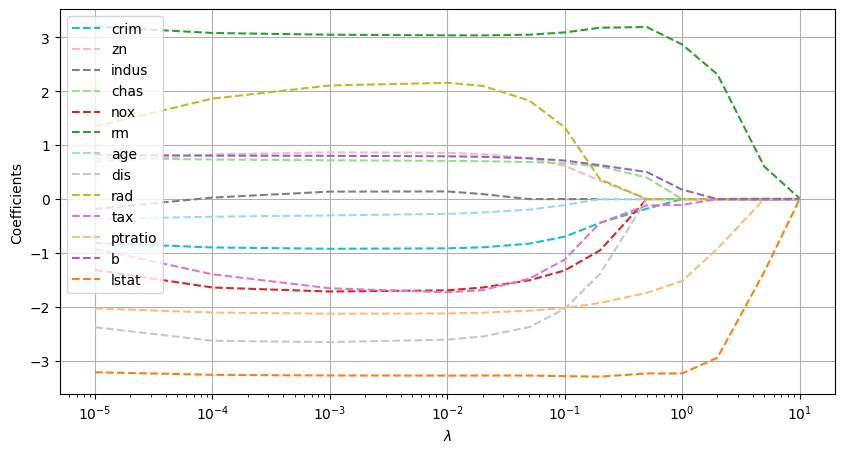

In [26]:
fig, ax = plt.subplots(figsize = (10,5))

w_s = np.array(w_s)

cmap = np.random.permutation(matplotlib.colormaps['tab20'].colors)

for i in range(X.shape[1]):
    plt.plot(ls, w_s[:,i],ls='--', label=df.columns[i], color=cmap[i])
    
    
zeroed_fet = []
eps = 1e-1

for i in range(len(ls)):
    zeroed_fet.append(np.argwhere(np.abs(w_s[i,:])<eps))

plt.xscale('log')
plt.xlabel('$\\lambda$')
plt.ylabel('Coefficients')
plt.grid()
plt.legend()

## 🔍 Identifying Key Features

As regularization strength increases, more coefficients are driven to zero.  
In our case, the **last 5 variables** that remain non-zero (i.e. most resilient to Lasso shrinkage) are:

- **LSTAT** — % lower status of the population
- **RM** — average number of rooms per dwelling
- **PTRATIO** — pupil-teacher ratio by town
- **B** — $1000 \cdot (Bk - 0.63)^2$, where Bk is the proportion of Black residents
- **CHAS** — Charles River dummy variable (1 if tract bounds river; 0 otherwise)

These variables are likely to be the **strongest predictors** of house prices, since keeping only them active still yields good model performance.

Let us now examine the **coefficients assigned** to these features by a Lasso model trained with $ \lambda = 0.5 $.
This will also allow us to interpret:
- Which variables have a **positive** impact on price
- Which have a **negative** impact

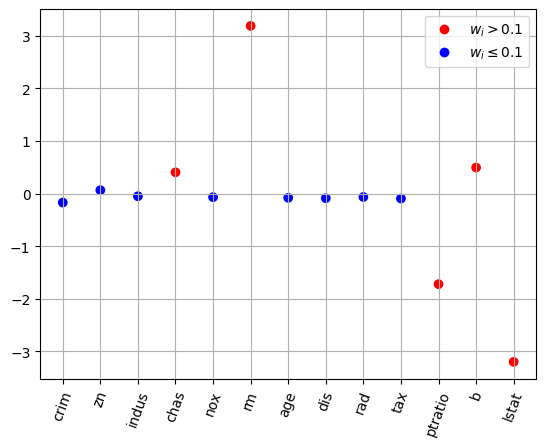

In [29]:
model = LassoRegression(w, b, lam=0.5)
model.fit(train_X,train_Y, lr = 1e-1, num_iter = 100000)

fig, ax = plt.subplots()

colors = np.where(np.abs(model.w)>2e-1,'red', 'blue')

ax.scatter(np.arange(len(model.w)), model.w, color=colors)
ax.set_xticks(np.arange(len(model.w)))
ax.set_xticklabels(df.columns[:-1], rotation=70)

ax.plot([],[], linestyle='', marker='o', color='red', label='$w_i>0.1$')
ax.plot([],[], linestyle='', marker='o', color='blue', label='$w_i\\leq 0.1$')

ax.grid()
ax.legend()